In [1]:
from pathlib import Path

root = Path("/media/esr/ssd0/dataset_ugm")
image_folder = root / "images"
depth_folder = root / "filled_depths"
metadata_folder = root / "metadata"

image_files = sorted(image_folder.glob("*.png"))
depth_files = sorted(depth_folder.glob("*.npy"))
metadata_files = sorted(metadata_folder.glob("*.yml"))

print(f"Found {len(image_files)} images, {len(depth_files)} depth files, and {len(metadata_files)} metadata files.")

Found 10341 images, 10341 depth files, and 10341 metadata files.


In [2]:
import yaml

first_metadata = metadata_files[0]
with open(first_metadata, 'r') as f:
    metadata = yaml.safe_load(f)
metadata

{'acceleration': {'x': 0.3544628918170929,
  'y': -9.680668830871582,
  'z': 0.790356457233429},
 'angular_velocity': {'x': 0.001065264455974102,
  'y': 0.02130528911948204,
  'z': -0.003195793367922306},
 'global_orient': {'w': 0.13253169218381725,
  'x': -0.12412335340382641,
  'y': 0.6695083597408406,
  'z': -0.7202689080779566},
 'global_pos': {'lat': -7.766785199999999, 'lon': 110.3754974},
 'global_vel': {'x': -1.102,
  'y': -1.9060000000000001,
  'z': 0.036000000000000004},
 'local_orient': {'w': 1.0, 'x': 0.0, 'y': 0.0, 'z': 0.0},
 'local_pos': {'x': 0.0, 'y': 0.0, 'z': 0.0},
 'magnetic': {'x': -3.299999889350147e-06,
  'y': -2.7750000299420208e-05,
  'z': -7.65999993745936e-06},
 'secs': '1736479104.337648947',
 'seq': '0000000091'}

In [3]:
output_folder = Path("output")
output_folder.mkdir(exist_ok=True)

# 1. Visualize segmentation

In [23]:
segmentation_folder = root / "segmentation"
if not segmentation_folder.exists():
    print("Please run the generate_segmentation.py first to generate the segmentation data.")
else:
    segmentation_files = sorted(segmentation_folder.glob("*.pkl"))
    print(f"Found {len(segmentation_files)} segmentation files.")

Found 10341 segmentation files.


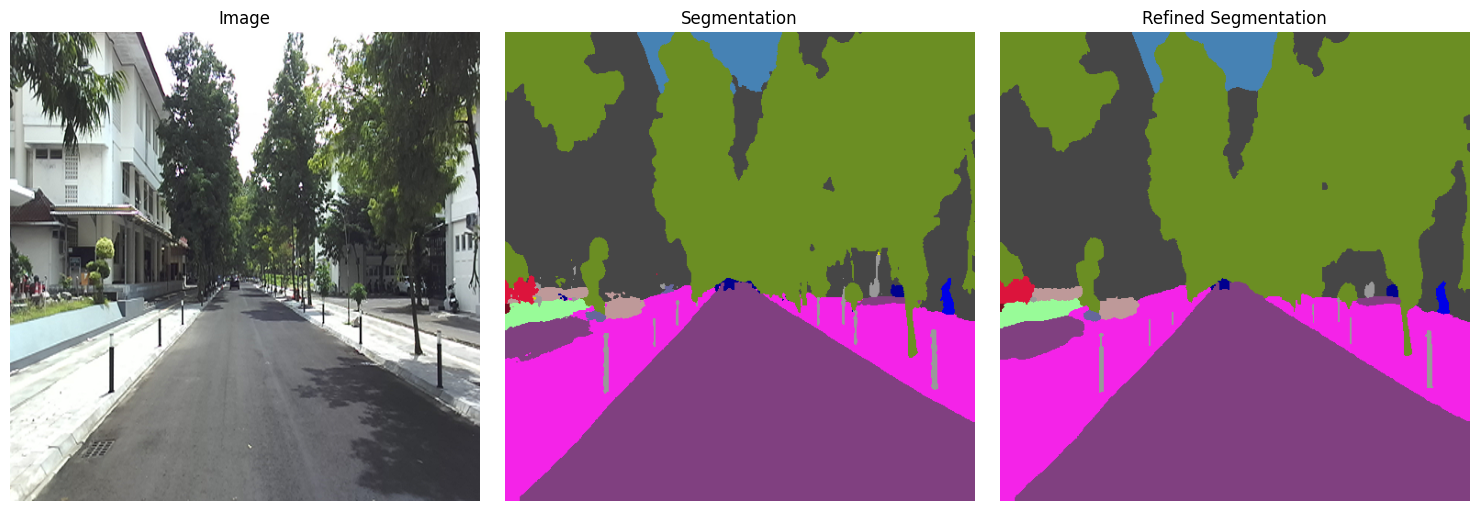

In [28]:
from generate_segmentation import colorize_segmentation
import matplotlib.pyplot as plt
import pickle
from PIL import Image

image_idx = 200

# Load the image
image = Image.open(image_files[image_idx]).convert("RGB").resize((512, 512))

# Load the segmentation data
segmentation = pickle.load(open(segmentation_files[image_idx], "rb"))
pred = segmentation["pred"].cpu()
segmentation_colored = colorize_segmentation(pred)

refined_pred = segmentation["refined"]
refined_segmentation_colored = colorize_segmentation(refined_pred)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Image")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(segmentation_colored)
plt.title("Segmentation")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(refined_segmentation_colored)
plt.title("Refined Segmentation")
plt.axis("off")
plt.tight_layout()
plt.show()

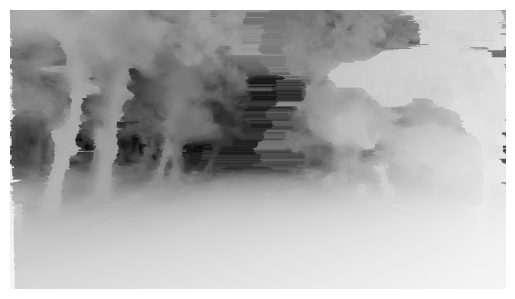

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_depth(depth):
    min_val = np.nanmin(depth)
    max_val = np.nanmax(depth)
    norm = (depth - min_val) / (max_val - min_val)
    inv_norm = 1 - norm  # Invert the normalization
    return (inv_norm * 255).astype(np.uint8)

depth = np.load(depth_files[110])
if np.all(depth[:, 0] == depth[:, 1]) and np.all(depth[:, 1] == depth[:, 2]):
    depth = depth[:, 0]
else:
    depth = depth.mean(axis=1)
depth = depth.reshape(360, 640)
norm_depth = normalize_depth(depth)
plt.imshow(norm_depth, cmap='gray')
plt.axis('off')
plt.show()


# 2. Visualize BEV

In [3]:
bev_folder = root / "bev"
if not bev_folder.exists():
    print("Please run the generate_bev.py first to generate the BEV data.")
else:
    bev_files = sorted(bev_folder.glob("*.pkl"))
    print(f"Found {len(bev_files)} BEV files.")

Found 10341 BEV files.


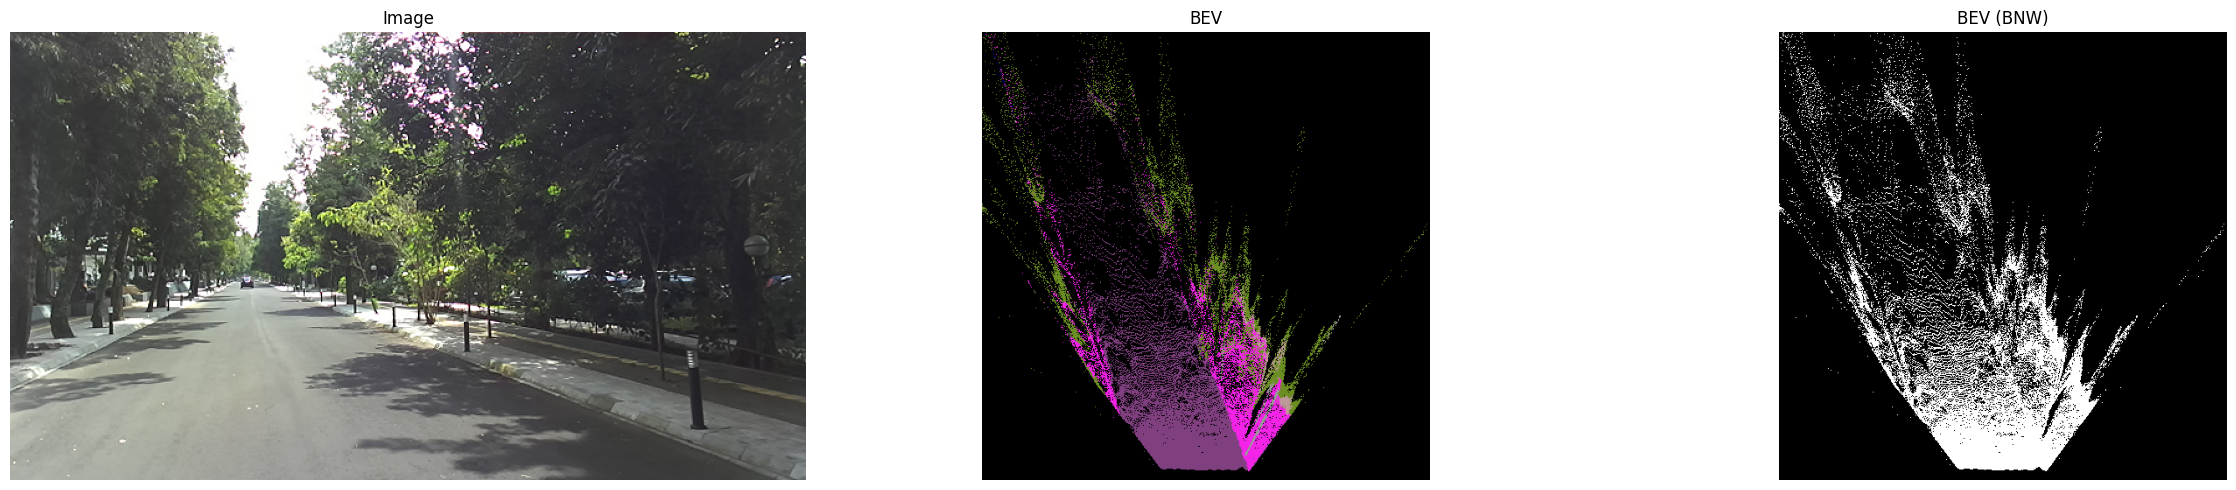

In [4]:
from generate_bev import mask_class, fill_bev
import matplotlib.pyplot as plt
import pickle
import cv2

image_idx = 100

# Load the image
image = cv2.imread(str(image_files[image_idx]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load the BEV data
bev_file = bev_files[image_idx]
with open(bev_file, "rb") as f:
    bev_data = pickle.load(f)
bev_bnw = bev_data["refined"]["bnw"]
bev_color = bev_data["refined"]["color"]

plt.figure(figsize=(25, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Image")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(bev_color)
plt.title("BEV")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(bev_bnw, cmap='gray')
plt.title("BEV (BNW)")
plt.axis("off")
plt.tight_layout()
plt.show()

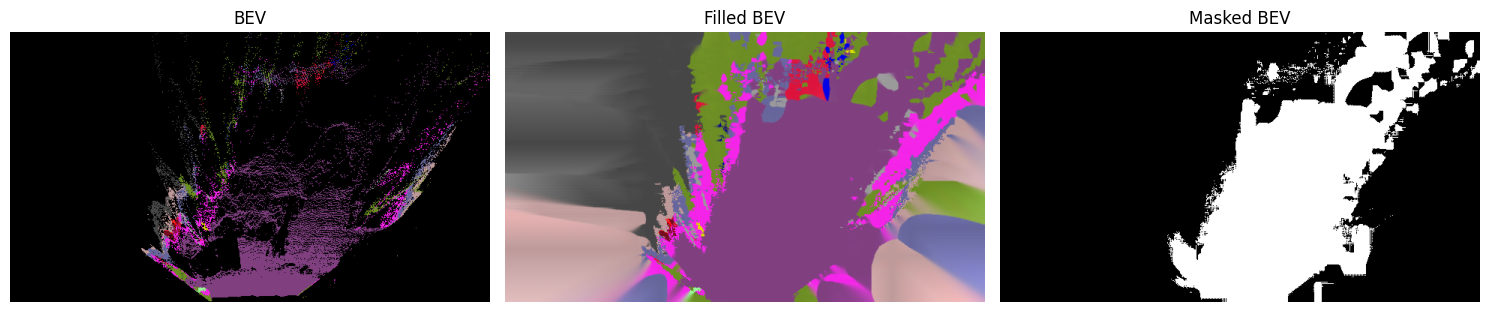

In [ ]:
filled_bev = fill_bev(bev_color)
masked_bev = mask_class(filled_bev, 0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(bev_color)
plt.title("BEV")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(filled_bev)
plt.title("Filled BEV")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(masked_bev)
plt.title("Masked BEV")
plt.axis("off")
plt.tight_layout()
plt.show()

# 3. Viusalize routes

In [4]:
import yaml
from tqdm import tqdm

routes_file = output_folder / "routes.yaml"
if not routes_file.exists():
    print("Please run the generate_routes.py first to generate the routes data.")
else:
    with open(routes_file, "r") as f:
        routes = yaml.safe_load(f)
        
meta = [yaml.safe_load(open(meta_file, "r")) for meta_file in tqdm(metadata_files)]

100%|██████████| 10341/10341 [02:55<00:00, 58.86it/s]


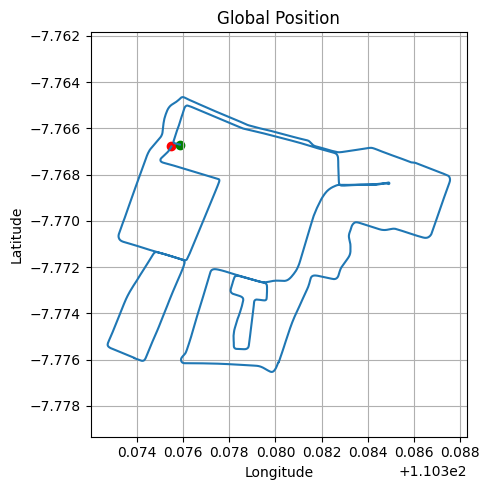

In [ ]:
import matplotlib.pyplot as plt

lat = [m['global_pos']['lat']  for m in meta]
lon = [m['global_pos']['lon']  for m in meta]

plt.figure(figsize=(5, 5))
plt.plot(lon, lat)
plt.scatter(lon[0], lat[0], color='red', label='Start')
plt.scatter(lon[-1], lat[-1], color='green', label='End')
plt.title("Global Position")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.tight_layout()
plt.axis("equal")
plt.show()

In [9]:
import folium
from folium import Element
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex

global_pos = [[m['global_pos']['lat'], m['global_pos']['lon']] for m in meta]
midpoint = [sum(x)/len(x) for x in zip(*global_pos)]

m = folium.Map(location=midpoint, zoom_start=16, tiles='CartoDB positron')

# add round markers
for i, (_, route) in enumerate(routes.items()):
    pos = list(zip(route['rp_lat'], route['rp_lon']))

    if i == 0:
        folium.CircleMarker(pos[0], radius=5, color="red").add_to(m)
    
    # Plot the route as a polyline
    folium.PolyLine(pos, weight=3, opacity=0.8).add_to(m)
    
    
    # add text label for the route
    # mid_idx = len(route['rp_lat']) // 2
    # folium.Marker(
    #     pos[mid_idx], 
    #     icon=folium.DivIcon(
    #         html=f'<div style="font-size: 10pt; font-weight: bold; color: #777">{i+1}</div>'
    #     )
    # ).add_to(m)
    
# add end marker
folium.CircleMarker(pos[-1], radius=5, color="black").add_to(m)

legend_html = """
<div style="
    position: fixed; 
    top: 50px; left: 100px; width: 170px; height: 90px; 
    background: white; z-index:9999; font-size:14px; border:2px solid #333; border-radius:8px; box-shadow:2px 2px 8px rgba(0,0,0,0.2); padding: 12px;">
    <b>Route Legend</b><br>
    <i style="background:red;border-radius:4px;width:18px;height:12px;display:inline-block;"></i> Start<br>
    <i style="background:black;border-radius:4px;width:18px;height:12px;display:inline-block;"></i> End
</div>
"""

m.get_root().html.add_child(Element(legend_html))

output_map_file = output_folder / "route_visualization.html"
m.save(str(output_map_file))

display(m)

In [ ]:
import folium
from folium import Element
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex

global_pos = [[m['global_pos']['lat'], m['global_pos']['lon']] for m in meta]
midpoint = [sum(x)/len(x) for x in zip(*global_pos)]

total_route = len(routes)
val = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
test = [23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
train = [i for i in range(total_route) if i not in val and i not in test]

# get color from viridis colormap
cmap = plt.get_cmap('viridis')
train_color = to_hex(cmap(0.0))
val_color = to_hex(cmap(0.5))
test_color = to_hex(cmap(1.0))

m = folium.Map(location=midpoint, zoom_start=16, tiles='CartoDB positron')

# add round markers
for i, (_, route) in enumerate(routes.items()):
    pos = list(zip(route['rp_lat'], route['rp_lon']))
    
    # Assign color based on split
    if i in train:
        color = train_color
    elif i in val:
        color = val_color
    elif i in test:
        color = test_color

    # Plot the route as a polyline
    folium.PolyLine(pos, color=color, weight=3, opacity=0.8).add_to(m)
    
    folium.CircleMarker(pos[0], radius=5, color="black").add_to(m)
    
    # add text label for the route
    mid_idx = len(route['rp_lat']) // 2
    folium.Marker(
        pos[mid_idx], 
        icon=folium.DivIcon(
            html=f'<div style="font-size: 10pt; font-weight: bold; color: #777">{i+1}</div>'
        )
    ).add_to(m)
    
# add end marker
folium.CircleMarker(pos[-1], radius=5, color="black").add_to(m)

legend_html = """
<div style="
    position: fixed; 
    top: 50px; left: 100px; width: 170px; height: 110px; 
    background: white; z-index:9999; font-size:14px; border:2px solid #333; border-radius:8px; box-shadow:2px 2px 8px rgba(0,0,0,0.2); padding: 12px;">
    <b>Route Legend</b><br>
    <i style="background:%s;border-radius:4px;width:18px;height:12px;display:inline-block;"></i> Train<br>
    <i style="background:%s;border-radius:4px;width:18px;height:12px;display:inline-block;"></i> Validation<br>
    <i style="background:%s;border-radius:4px;width:18px;height:12px;display:inline-block;"></i> Test
</div>
""" % (train_color, val_color, test_color)

m.get_root().html.add_child(Element(legend_html))

output_map_file = output_folder / "route_visualization.html"
m.save(str(output_map_file))

display(m)

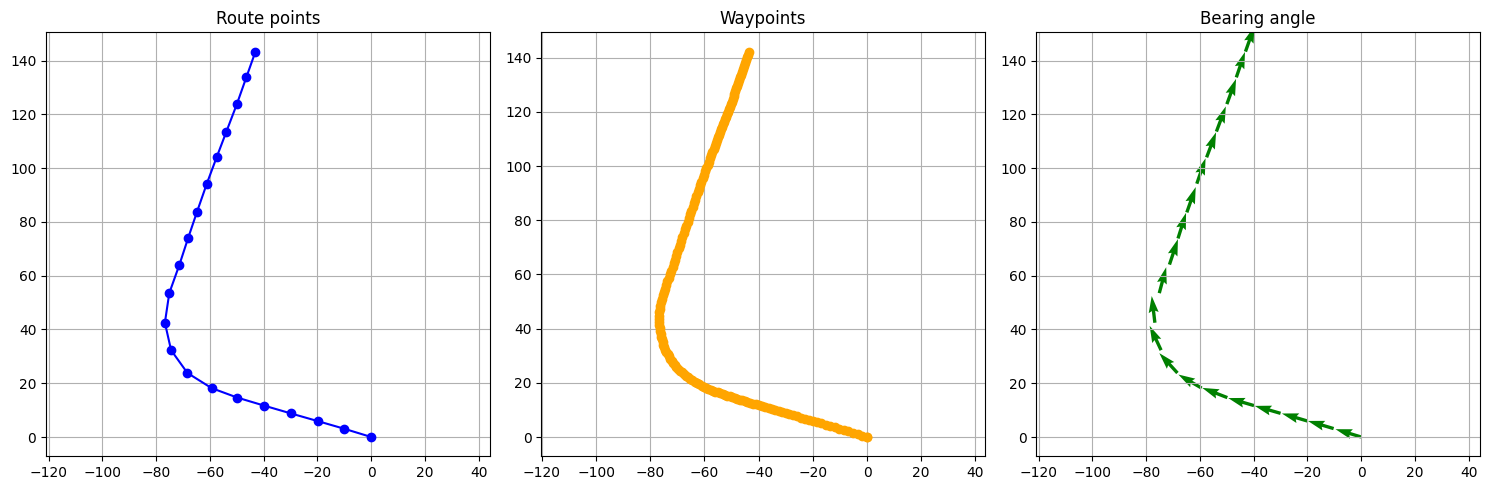

In [11]:
import numpy as np
import matplotlib.pyplot as plt

route_idx = 13 # start from 1 for the first route

route_1 = routes[f"route_{route_idx}"]
rp_x = route_1["rp_x"]
rp_y = route_1["rp_y"]
wp_x = route_1["wp_x"]
wp_y = route_1["wp_y"]
yaw = route_1["yaw"]
speed = route_1["speed"]

plt.figure(figsize=(15, 5))
# plt.suptitle(f"Route {route_idx} Visualization", fontsize=16)
plt.subplot(1, 3, 1)
plt.plot(rp_x, rp_y, marker='o', linestyle='-', color='blue', label='Reference Path')
plt.title("Route points")
plt.axis("equal")
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(wp_x, wp_y, marker='o', linestyle='--', color='orange', label='Waypoints')
plt.title("Waypoints")
plt.axis("equal")
plt.grid()

plt.subplot(1, 3, 3)
N = len(yaw)
num_samples = len(rp_x)
indices = [round(i * (N - 1) / (num_samples - 1)) for i in range(num_samples)]
result = [yaw[i] for i in indices]
plt.quiver(rp_x, rp_y, np.cos(result), np.sin(result), angles='xy', scale_units='xy', scale=0.1, color='green', label='Yaw Direction')
plt.title("Bearing angle")
plt.axis("equal")
plt.grid()

plt.tight_layout()
plt.show()

207


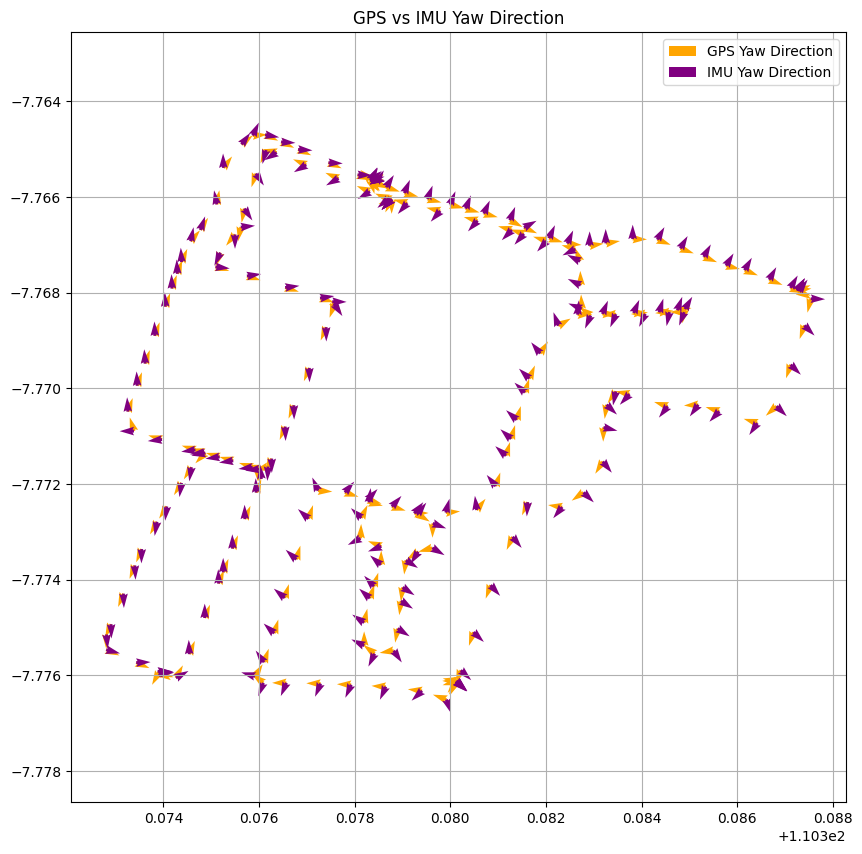

In [ ]:
from generate_routes import latlon_to_yaw, quaternion_to_yaw
import numpy as np

lat = [m['global_pos']['lat'] for m in meta][::50]
lon = [m['global_pos']['lon'] for m in meta][::50]
gps_yaw = latlon_to_yaw(lat[1:], lon[1:], lat[:-1], lon[:-1], offset=np.pi / 2.0)
gps_yaw = np.append(gps_yaw, gps_yaw[-1])

quaternion = [m['local_orient'] for m in meta][::50]
imu_yaw = quaternion_to_yaw(quaternion, offset=np.pi * 1.5)

plt.figure(figsize=(10, 10))
scale = 0.003
plt.quiver(lon, lat, np.cos(gps_yaw)*scale, np.sin(gps_yaw)*scale, angles='xy', scale_units='xy', scale=10, color='orange', label='GPS Yaw Direction')
plt.quiver(lon, lat, np.cos(imu_yaw)*scale, np.sin(imu_yaw)*scale, angles='xy', scale_units='xy', scale=10, color='purple', label='IMU Yaw Direction')
plt.title("GPS vs IMU Yaw Direction")
plt.axis("equal")
plt.grid()
plt.legend()
plt.show()